# פרויקט חיזוי תאונות דרכים בישראל

פרויקט זה נועד לפתח כלי אנליטי מבוסס למידת מכונה לזיהוי וחיזוי מוקדי סיכון לתאונות דרכים ברחבי ישראל. מטרת הפרויקט היא לסייע לרשות הלאומית לבטיחות בדרכים (רלב"ד) בקבלת החלטות מבוססות-נתונים לצורך הפחתת מספר התאונות והצלת חיים.  
הפרויקט עושה שימוש במידע רב שנתי (2018–2023) הכולל נתוני תאונות דרכים ממקורות ממשלתיים.

במהלך העבודה נבנו שלושה מודלים מרכזיים:
- חיזוי חומרת התאונה לפי תנאים סביבתיים, תשתיות, ותנאי כביש.
- חיזוי אזורים בעלי סיכון מוגבר להתרחשות תאונות.
- חיזוי זמן (חודש בשנה) שבו הסיכון לתאונה גבוה.

In [1]:
import pandas as pd

# קריאה של קובץ CSV
data = pd.read_csv("All_data_csv.csv")

# הצגת 5 השורות הראשונות כדי לבדוק את הנתונים
print(data.head())


   pk_teuna_fikt  sug_tik  THUM_GEOGRAFI  SUG_DEREH  SEMEL_YISHUV  REHOV1  \
0     2018000004        1              1          1           841   104.0   
1     2018000018        1              1          1          4000   896.0   
2     2018000030        1              1          1          7100  1035.0   
3     2018000037        1              1          4             0     NaN   
4     2018000049        1              1          3             0     NaN   

   REHOV2  BAYIT  ZOMET_IRONI  KVISH1  ...  MEKOM_HAZIYA  KIVUN_HAZIYA  MAHOZ  \
0   105.0    NaN          2.0     NaN  ...             0             9      4   
1   825.0    NaN   10210522.0     NaN  ...             0             9      3   
2   496.0    NaN   10800341.0     NaN  ...             0             9      6   
3     NaN    NaN          NaN    91.0  ...             0             9      2   
4     NaN    NaN          NaN     4.0  ...             0             9      3   

   NAFA  EZOR_TIVI  MAAMAD_MINIZIPALI  ZURAT_ISHUV

### מודל מס' 1 – Random Forest: חיזוי חומרת תאונה

מודל זה נבנה במטרה לחזות את **חומרת התאונה** (קל, בינוני, קשה, קטלני) בהתבסס על מאפייני הדרך, הזמן והתנאים בעת התאונה.  
המודל עושה שימוש באלגוריתם **Random Forest Classifier**, המתבסס על עצי החלטה לצורך שיפור הדיוק והפחתת הטיה.  

המודל נועד לשמש ככלי תומך החלטה לזיהוי מוקדים בעייתיים ולשיפור מנגנוני המניעה של תאונות דרכים חמורות.


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# טוען את הנתונים
file_path = 'All_data_csv.csv'
df = pd.read_csv(file_path)
# בחירת משתנים (אותם משתנים כמו בלוגיסטית)
features = ["SUG_DEREH", "YOM_LAYLA", "MEHIRUT_MUTERET", "TEURA", "MEZEG_AVIR", "PNE_KVISH", "SUG_TEUNA"]
target = "HUMRAT_TEUNA"

# הסרת רשומות עם ערכים חסרים
df = df.dropna(subset=features + [target])

# הפרדת נתונים
X = df[features]
y = (df[target] > 1).astype(int)  # הפיכת חומרת התאונה לקטגורית: 1 = חמורה, 0 = לא חמורה

# חלוקה לסט אימון וסט בדיקה
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# איזון הנתונים עם SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
# בניית המודל והגדרת מספר העצים
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

Classification Report:
               precision    recall  f1-score   support

           0       0.05      0.58      0.09       363
           1       0.98      0.70      0.82     13016

    accuracy                           0.70     13379
   macro avg       0.52      0.64      0.46     13379
weighted avg       0.96      0.70      0.80     13379

          Variable  Importance
6        SUG_TEUNA    0.350514
0        SUG_DEREH    0.219234
2  MEHIRUT_MUTERET    0.185306
3            TEURA    0.089186
5        PNE_KVISH    0.081291
4       MEZEG_AVIR    0.048844
1        YOM_LAYLA    0.025624


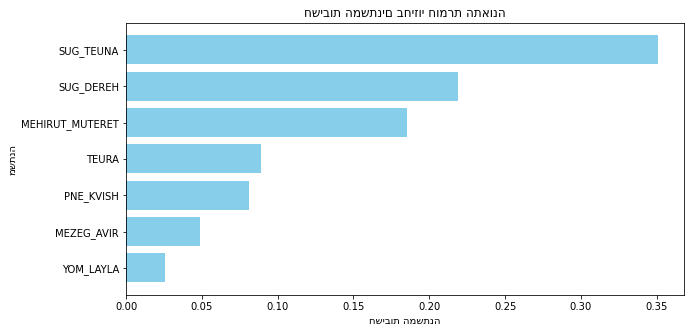

החיזוי עבור התאונה החדשה: חמורה
ההסתברות שהתאונה חמורה: 0.88775


In [10]:
print("Classification Report:\n", classification_report(y_test, y_pred))
# חשיבות המשתנים במודל
import matplotlib.pyplot as plt
importances = model.feature_importances_
feature_names = X.columns

# יצירת DataFrame להצגת התוצאות
feature_importance_df = pd.DataFrame({'Variable': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# הדפסת החשיבות של כל משתנה
print(feature_importance_df)
# יצירת גרף
plt.figure(figsize=(10, 5))
plt.barh(feature_importance_df['Variable'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('חשיבות המשתנה')
plt.ylabel('משתנה')
plt.title('חשיבות המשתנים בחיזוי חומרת התאונה')
plt.gca().invert_yaxis()  # הופך את הגרף כדי שהערך הגבוה ביותר יהיה למעלה
plt.show()

#הרצת המודל:
new_data = {
    "SUG_DEREH": [1],  # סוג דרך (למשל, עירוני)
    "YOM_LAYLA": [0],  # תאורה (למשל, יום)
    "MEHIRUT_MUTERET": [50],  # מהירות מותרת (למשל, 50 קמ"ש)
    "TEURA": [1],  # תאורה (למשל, מואר)
    "MEZEG_AVIR": [0],  # מזג אוויר (למשל, בהיר)
    "PNE_KVISH": [2],  # פנייה (למשל, פנייה חדה)
    "SUG_TEUNA": [0]  # סוג תאונה (למשל, התנגשות חזיתית)
}
new_df = pd.DataFrame(new_data)

# ניבוי עם המודל של רנדום פורסט
new_prediction = model.predict(new_df)
new_prediction_proba = model.predict_proba(new_df)[:, 1]  

print("החיזוי עבור התאונה החדשה:", "חמורה" if new_prediction[0] == 1 else "לא חמורה")
print("ההסתברות שהתאונה חמורה:", new_prediction_proba[0])


### מודל מס' 2 – Random Forest: חיזוי אזורים מסוכנים

מודל זה נועד לזהות **אזורים גאוגרפיים בעלי סיכון גבוה לתאונות דרכים**, על בסיס נתוני תאונות קודמות, תנאי סביבה, זמן ומאפייני הדרך.  
המודל עושה שימוש באלגוריתם **Random Forest Classifier** לצורך סיווג האזור (YEHIDA) לרמת סיכון בהתאם למאפייני התאונה, מתוך מטרה לסייע בקבלת החלטות תשתיתיות ואכיפתיות ולצמצום תאונות עתידיות.


In [11]:


# נניח שאם יש יותר מ-2 תאונות באזור, אנחנו מסווגים אותו כ"אזור מסוכן"
df['SOGEN'] = (df.groupby(['X', 'Y'])['HUMRAT_TEUNA'].transform('count') > 2).astype(int)

# בחירת משתנים
features = ["SUG_DEREH", "MEHIRUT_MUTERET", "PNE_KVISH", "TEURA", "MEZEG_AVIR", "SUG_TEUNA", "X", "Y"]
target = 'SOGEN'

# טפל בערכים חסרים
imputer = SimpleImputer(strategy='mean')
df[features] = imputer.fit_transform(df[features])

# הפרדת נתונים
X = df[features]
y = df[target]

# חלוקה לסט אימון וסט בדיקה
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# איזון הנתונים באמצעות SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# נרמול הנתונים
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# בניית המודל עם רנדום פורסט
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ניבוי וניתוח תוצאות
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# הצגת המשתנים החשובים
feature_importance = model.feature_importances_
for feature, importance in zip(features, feature_importance):
    print(f"{feature}: {importance}")

# לנקות רווחים מיותרים בכל העמודות
df.columns = df.columns.str.strip()
# ואז תוכל להריץ את הקוד שלך שוב
features_with_weather_time = features + ["MEZEG_AVIR", "SHAA"]

#הרצת המודל:
# חיזוי עבור דגימה חדשה 
import numpy as np
new_data = pd.DataFrame({
    'SUG_DEREH': [1],  
    'MEHIRUT_MUTERET': [0],  
    'PNE_KVISH': [1],  
    'TEURA': [0],  
    'MEZEG_AVIR': [0],  
    'SUG_TEUNA': [0],  
    'X': [250000],  
    'Y': [670000]   
})

# נרמל את הנתונים בצורה תואמת לפני החיזוי
new_data_scaled = scaler.transform(new_data)
# חיזוי עבור הדגימה
prediction = model.predict(new_data_scaled)
# הצגת החיזוי
print("חיזוי עבור הדגימה החדשה:", prediction)



Accuracy: 0.7635099783242395
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.72      0.74      6156
           1       0.77      0.80      0.79      7223

    accuracy                           0.76     13379
   macro avg       0.76      0.76      0.76     13379
weighted avg       0.76      0.76      0.76     13379

SUG_DEREH: 0.13195569226988016
MEHIRUT_MUTERET: 0.04677377914117984
PNE_KVISH: 0.013405280587124835
TEURA: 0.03383469205850256
MEZEG_AVIR: 0.01216334532676437
SUG_TEUNA: 0.08581831384626559
X: 0.3369513165036036
Y: 0.339097580266679
חיזוי עבור הדגימה החדשה: [0]


### מודל מס' 3 – Prophet: ניתוח וחיזוי סדרות זמן של תאונות דרכים

מודל זה מבוסס על אלגוריתם **Prophet** שפותח על ידי Facebook, ומשמש לניתוח וחיזוי של **סדרות זמן**.  
בפרויקט זה נעשה שימוש ב־Prophet על מנת לחזות את מגמות התאונות לאורך ציר הזמן – לפי חודש בשנה – תוך התחשבות בעונתיות, טרנדים ארוכי טווח וחגים.  
המטרה היא לזהות תקופות בהן הסיכון לתאונות עולה, ובכך לאפשר **התערבות מונעת מדויקת** מצד הרשויות.

המודל מותאם במיוחד לנתונים עם רכיבים עונתיים חזקים וחסינות לרעש, והוא מאפשר גם פרשנות נוחה של התוצאות דרך גרפים ברורים של מגמות ותחזיות.


In [49]:
import pandas as pd

# מסננים את הנתונים לשנים 2018-2023 בלבד
df = df[df['SHNAT_TEUNA'].between(2018, 2023)]

# סכום התאונות לכל חודש ושנה
df_monthly = df.groupby(['SHNAT_TEUNA', 'HODESH_TEUNA'])['SUG_TEUNA'].sum().reset_index()

# נוודא שהנתונים ממויינים לפי שנה וחודש
df_monthly = df_monthly.sort_values(by=['SHNAT_TEUNA', 'HODESH_TEUNA']).reset_index(drop=True)

# הצגת התוצאה
print(df_monthly.head(75))


    SHNAT_TEUNA  HODESH_TEUNA  SUG_TEUNA
0          2018             1       3487
1          2018             2       3447
2          2018             3       4036
3          2018             4       3341
4          2018             5       3774
..          ...           ...        ...
67         2023             8       2923
68         2023             9       2459
69         2023            10       1673
70         2023            11       2353
71         2023            12       2464

[72 rows x 3 columns]


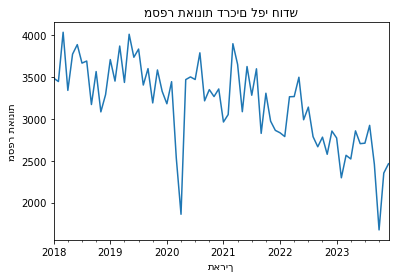

In [20]:
# יצירת אינדקס זמן
df_monthly['date'] = pd.to_datetime(df_monthly['SHNAT_TEUNA'].astype(str) + '-' + df_monthly['HODESH_TEUNA'].astype(str).str.zfill(2), format='%Y-%m')

# הגדרת סדרת הזמן (העמודה מספר תאונות לפי תאריך)
df_monthly.set_index('date', inplace=True)
series = df_monthly['SUG_TEUNA']

# הצגת סדרת הזמן
series.plot()
plt.title('מספר תאונות דרכים לפי חודש')
plt.xlabel('תאריך')
plt.ylabel('מספר תאונות')
plt.show()


17:07:55 - cmdstanpy - INFO - Chain [1] start processing
17:07:56 - cmdstanpy - INFO - Chain [1] done processing


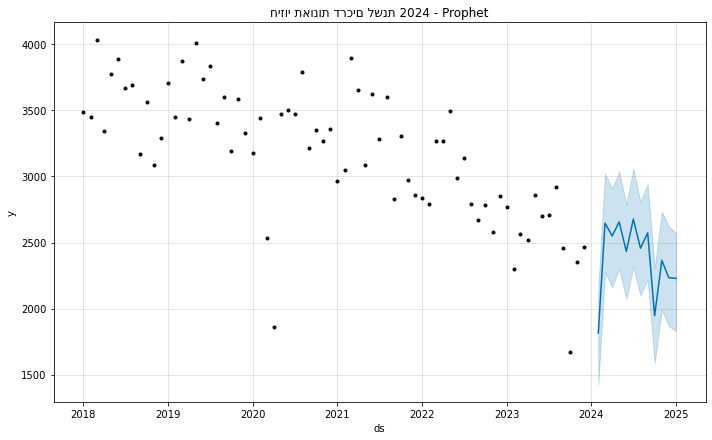

In [21]:
from prophet import Prophet
import pandas as pd

# הכנת הנתונים ל-Prophet
df_prophet = df_monthly[['SUG_TEUNA']].reset_index()
df_prophet.columns = ['ds', 'y']  # Prophet מצפה לעמודת 'ds' (תאריך) ו-'y' (ערך)

# יצירת המודל
model_prophet = Prophet()

# התאמת המודל לנתונים
model_prophet.fit(df_prophet)

# יצירת תאריכים עתידיים (12 חודשים נוספים)
last_date = df_prophet['ds'].max()  # תאריך אחרון מהנתונים
future_dates = pd.date_range(last_date, periods=13, freq='M')[1:]  # יוצרים 12 חודשים לאחר התאריך האחרון
future = pd.DataFrame(future_dates, columns=['ds'])  # מבנה מתאים עבור prophet

# חיזוי ל-12 חודשים (2024)
forecast = model_prophet.predict(future)

# הצגת החיזוי
model_prophet.plot(forecast)
plt.title('חיזוי תאונות דרכים לשנת 2024 - Prophet')
plt.show()


In [ ]:
# הצגת החיזויים עבור 2024 (רק את החודשים שהמודל חזה עבורם)
forecast_2024 = forecast[['ds', 'yhat']].rename(columns={'ds': 'Date', 'yhat': 'Predicted_Accidents'})

# הצגת התוצאות של החיזוי (ללא השוואה לערכים האמיתיים)
print(forecast_2024)

# אם תרצה לצאת למבנה DataFrame עם מידע נוסף (למשל, הערות/הסברים נוספים)
forecast_2024['Year'] = forecast_2024['Date'].dt.year
forecast_2024['Month'] = forecast_2024['Date'].dt.month

print(forecast_2024)


         Date  Predicted_Accidents
0  2024-01-31          1814.705729
1  2024-02-29          2646.177533
2  2024-03-31          2549.302017
3  2024-04-30          2655.834243
4  2024-05-31          2432.129785
5  2024-06-30          2676.863317
6  2024-07-31          2456.548858
7  2024-08-31          2572.781763
8  2024-09-30          1945.459191
9  2024-10-31          2365.126535
10 2024-11-30          2233.572655
11 2024-12-31          2228.511796
         Date  Predicted_Accidents  Year  Month
0  2024-01-31          1814.705729  2024      1
1  2024-02-29          2646.177533  2024      2
2  2024-03-31          2549.302017  2024      3
3  2024-04-30          2655.834243  2024      4
4  2024-05-31          2432.129785  2024      5
5  2024-06-30          2676.863317  2024      6
6  2024-07-31          2456.548858  2024      7
7  2024-08-31          2572.781763  2024      8
8  2024-09-30          1945.459191  2024      9
9  2024-10-31          2365.126535  2024     10
10 2024-11-30    